In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist


In [2]:
def build_reciprocal_space_c_matrix(c1, c2, kx_list, ky_list):
    # First build up mesh grid of kspace size len(kx), len(ky)
    kxx, kyy = np.meshgrid(kx_list,ky_list)    
    ones = np.ones((len(kx_list),len(ky_list))) # ones will be used for kronecker products

    c_base = c1*np.array([[0,1,1,0],[1,0,0,1],[1,0,0,1],[0,1,1,0]]) #This builds up the real part of the matrix
    c_kron_prod = np.einsum('ij,kl->ijkl', ones, c_base) 
    # kronecker product so every point in kspace has the same real parts shape (len(kx), len(ky), 4, 4)

    kx_c_base = np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1], [0,0,-1,0]]) # Here we are defining the matrix that contains kx entries
    kx_kron_prod = np.einsum('ij,kl->ijkl', kxx, kx_c_base) # kronecker product of kx entries with all kx points to build (len(kx), len(ky), 4, 4) matrix
    c2_kx = c2*np.exp(1.0j*kx_kron_prod)

    ky_c_base = np.array([[0,0,-1,0],[0,0,0,-1], [1,0,0,0], [0,1,0,0]]) # Define ky entries 
    ky_kron_prod = np.einsum('ij,kl-> ijkl', kyy, ky_c_base) # kronecker product of ky entries with all ky points to build (len(kx), len(ky), 4, 4) matrix
    c2_ky = c2*np.exp(1.0j*ky_kron_prod)
    
    c_matrix = c_kron_prod + c2_kx + c2_ky # sum up real and imaginary (both kx and ky) matrices
    # print(np.shape(c_matrix))
    eigvals, eigvecs = np.linalg.eigh(c_matrix) #find eigenvalues and eigenvectors for all 
    # print(np.shape(eigvals))

    return eigvals, eigvecs

In [3]:
kx = np.linspace(0,2*np.pi,100)
ky = np.linspace(0,2*np.pi,100)
props, efield = build_reciprocal_space_c_matrix(1,8,kx,ky)

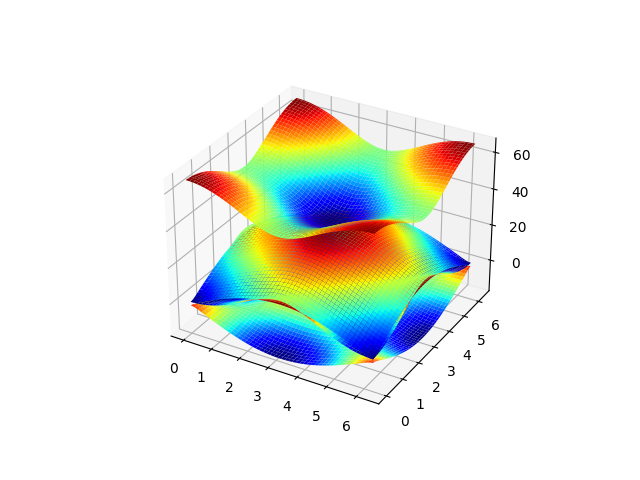

In [4]:
kxx, kyy = np.meshgrid(kx,ky)    
fig_cont = plt.figure()
ax = fig_cont.add_subplot(111,projection='3d')
for i in range(np.shape(props)[-1]):
    ax.plot_surface(kxx, kyy, props[:,:,i], cmap='jet')
plt.show()

In [5]:
def build_square(n,m, pitch):
    a_1 = np.array([pitch,0])
    a_2 = np.array([0,pitch])
    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list = np.array(coord_list)
    # print(coord_list_shifted)

    centered_coord_list = coord_list - ((n-1)*a_1 + (m-1)*a_2)/2

    return centered_coord_list

def show_2d_ssh(point_list, m, pitch):
    coupling_matrix = np.zeros((len(point_list[:,0]),len(point_list[:,0])),dtype=complex)
    square_point_tree = spat.cKDTree(point_list, leafsize=100)
    nearest_neighbour_array = square_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    fig_lattice_lines = plt.figure(figsize=(4,4))
    ax_lattice_lines = fig_lattice_lines.add_subplot(111)

    for i in nearest_neighbour_array:
        if (i[0]//m == i[1]//m):
            if (i[0]%2 != 0):
                x_points = [point_list[i[0]][0],point_list[i[1]][0]]
                y_points = [point_list[i[0]][1],point_list[i[1]][1]]
                ax_lattice_lines.plot(x_points, y_points, ls='-',color='#94A89A')
            if (i[0]%2 == 0):
                x_points = [point_list[i[0]][0],point_list[i[1]][0]]
                y_points = [point_list[i[0]][1],point_list[i[1]][1]]
                ax_lattice_lines.plot(x_points, y_points, ls='-',color='#EFB0A1')
        else:
            if ((i[0]//m) % 2 == 0):            
                x_points = [point_list[i[0]][0],point_list[i[1]][0]]
                y_points = [point_list[i[0]][1],point_list[i[1]][1]]
                ax_lattice_lines.plot(x_points, y_points, ls='-',color='#EFB0A1')
            if ((i[0]//m) % 2 != 0):
                x_points = [point_list[i[0]][0],point_list[i[1]][0]]
                y_points = [point_list[i[0]][1],point_list[i[1]][1]]
                ax_lattice_lines.plot(x_points, y_points, ls='-',color='#94A89A')

# print(nearest_neighbour_array)
    plt.show()

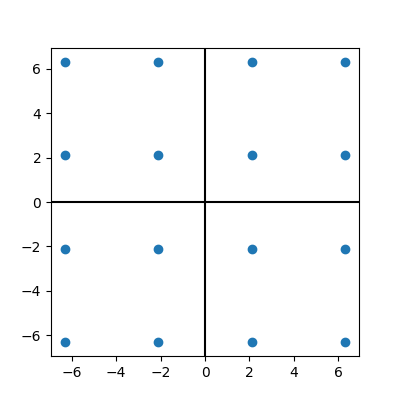

In [42]:
PITCH = 4.2
M = 4
b_10_list = build_square(M, M, PITCH)

fig_lattice_plot = plt.figure(figsize=(4,4))
ax_lattice_plot = fig_lattice_plot.add_subplot(111)
ax_lattice_plot.axhline(0, color='black')
ax_lattice_plot.axvline(0, color='black')
ax_lattice_plot.scatter(b_10_list[:,0], b_10_list[:,1])
ax_lattice_plot.set_aspect('equal')

plt.show()

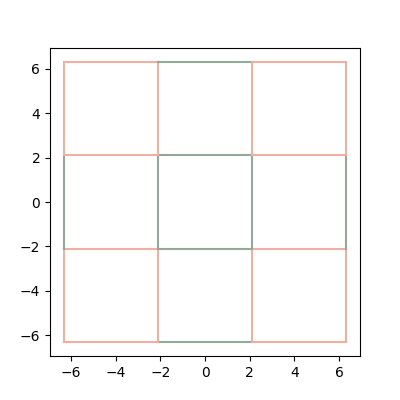

In [43]:
show_2d_ssh(b_10_list, M, PITCH)

In [48]:
def solve_2d_ssh(point_list, m, pitch, c1, c2, c3):
    coupling_matrix = np.zeros((len(point_list[:,0]),len(point_list[:,0])),dtype=np.complex128)
    square_point_tree = spat.cKDTree(point_list, leafsize=100)
    next_and_neighbour_array = square_point_tree.query_pairs(np.sqrt(2*pitch**2)+0.001, output_type = 'ndarray')
    nearest_neighbour_array = square_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')
    
    # easiest to create a list of tuples to remove any nearest neighbours from all pairs
    #  within next-nearest neighbour distance
    tup_all_list = [(i[0],i[1]) for i in next_and_neighbour_array]
    tup_nn_list = [(i[0],i[1]) for i in nearest_neighbour_array]
    tup_next_n_list = [i for i in tup_all_list if i not in tup_nn_list]


    for i in nearest_neighbour_array:
        if (i[0]//m == i[1]//m):
            if (i[0]%2 != 0):
                coupling_matrix[i[0],i[1]] = c1
                coupling_matrix[i[1],i[0]] = c1
            if (i[0]%2 == 0):
                coupling_matrix[i[0],i[1]] = c2
                coupling_matrix[i[1],i[0]] = c2
        else:
            if ((i[0]//m) % 2 == 0): 
                coupling_matrix[i[0],i[1]] = c2  
                coupling_matrix[i[1],i[0]] = c2          
            if ((i[0]//m) % 2 != 0):
                coupling_matrix[i[0],i[1]] = c1
                coupling_matrix[i[1],i[0]] = c1

    for n in tup_next_n_list:
        coupling_matrix[n[0],n[1]] = c3
        coupling_matrix[n[1],n[0]] = c3
    for a in range(np.shape(coupling_matrix)[0]):
        print(coupling_matrix[:,a])
    eigvals, eigvecs = np.linalg.eigh(coupling_matrix)
    return eigvals, eigvecs

In [49]:
betas, betavecs = solve_2d_ssh(b_10_list, M, PITCH, 246, 68,0)

[ 0.+0.j 68.+0.j  0.+0.j  0.+0.j 68.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
[ 68.+0.j   0.+0.j 246.+0.j   0.+0.j   0.+0.j  68.+0.j   0.+0.j   0.+0.j
   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j]
[  0.+0.j 246.+0.j   0.+0.j  68.+0.j   0.+0.j   0.+0.j  68.+0.j   0.+0.j
   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j]
[ 0.+0.j  0.+0.j 68.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j 68.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
[ 68.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j  68.+0.j   0.+0.j   0.+0.j
 246.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j]
[  0.+0.j  68.+0.j   0.+0.j   0.+0.j  68.+0.j   0.+0.j 246.+0.j   0.+0.j
   0.+0.j 246.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j]
[  0.+0.j   0.+0.j  68.+0.j   0.+0.j   0.+0.j 246.+0.j   0.+0.j  68.+0.j
   0.+0.j   0.+0.j 246.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j]
[  

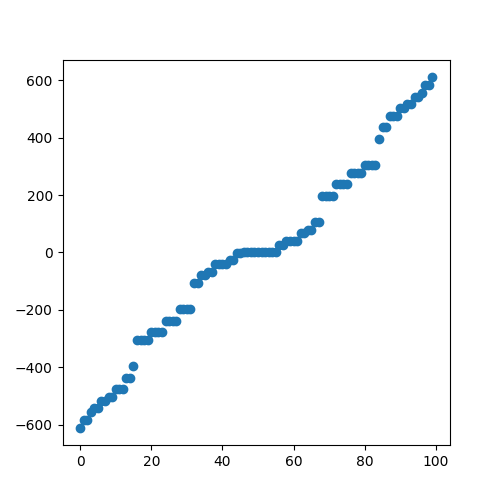

In [39]:
fig_props = plt.figure(figsize=(5,5))
ax_props = fig_props.add_subplot(111)

ax_props.scatter(np.arange(len(betas)), betas)
plt.show()

In [40]:
# For nice plotting of eigenvectors 
def plot_coloured_chain(intensities, circ_size, circ_locations, label):
    """
        Function for visualising the eigenvectors as fibre core excitations.
        Plots a lattice of circles with color corresponding to intensity.    
    """
    fig_chain = plt.figure(figsize=(5,5))
    ax_chain = fig_chain.add_subplot(111)
    intensities = intensities/np.sum(intensities)
    circ_list = []
    norm = colors.Normalize(vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 

   
    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    plt.show()     
    return 

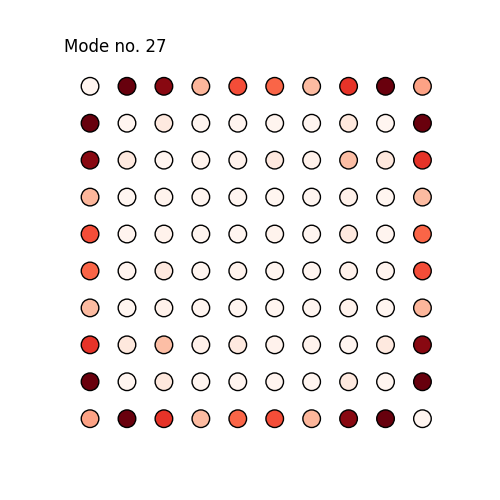

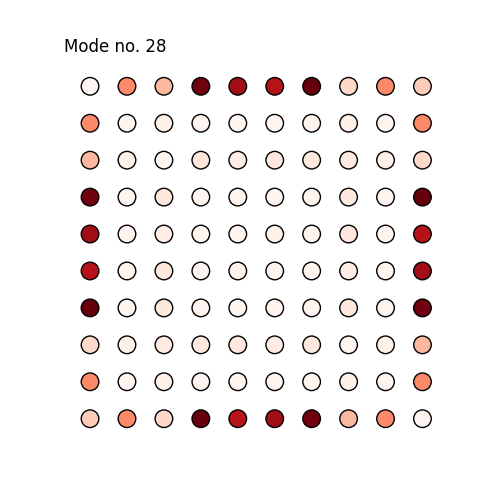

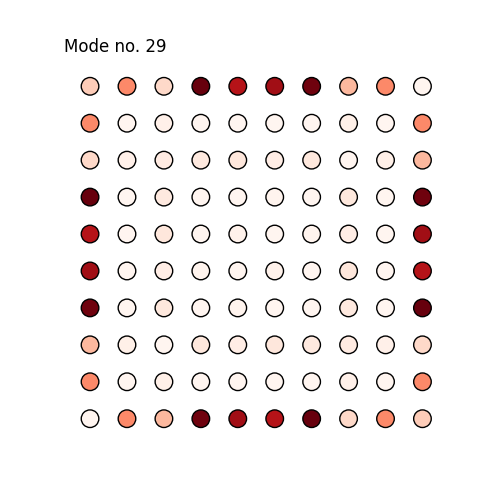

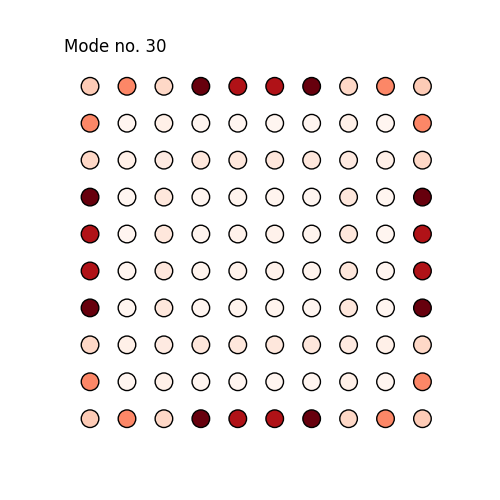

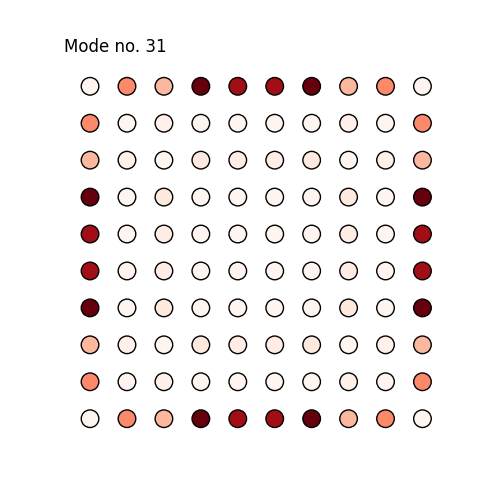

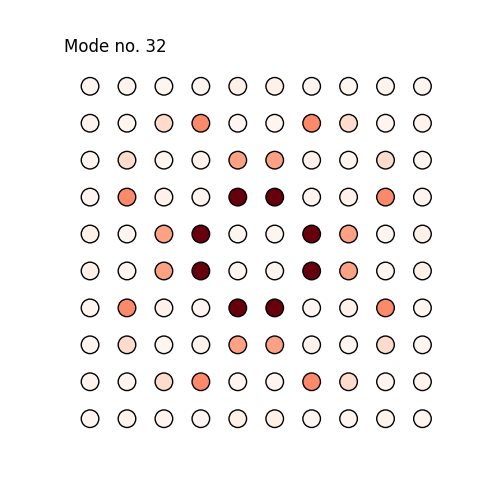

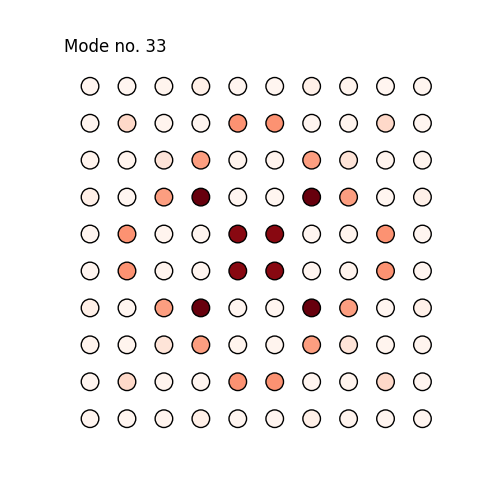

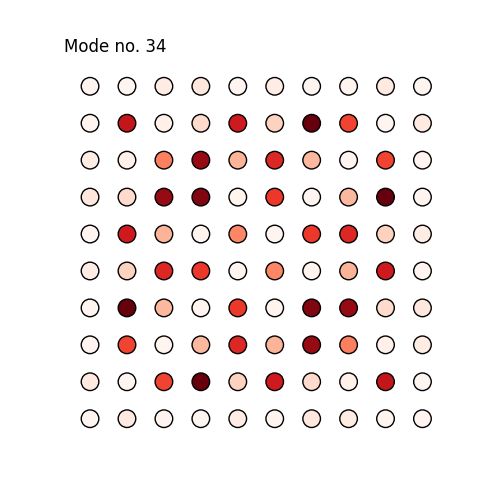

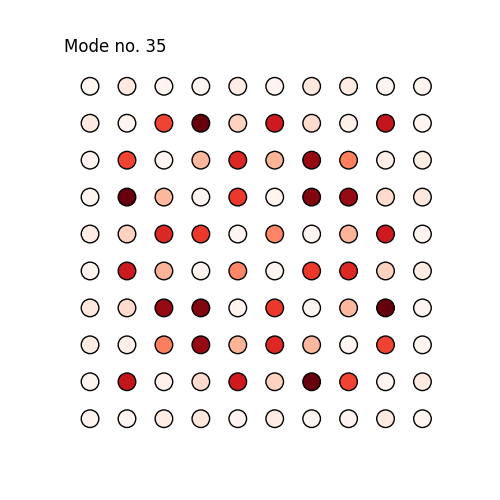

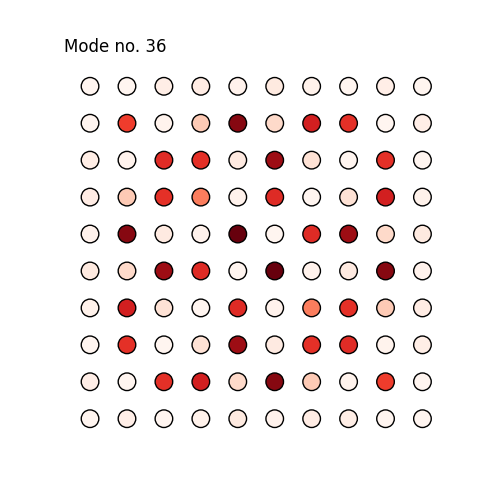

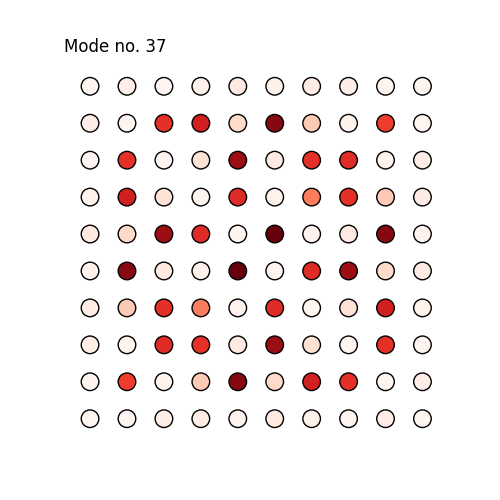

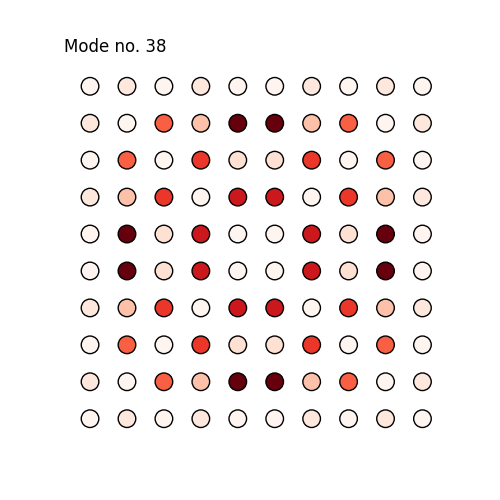

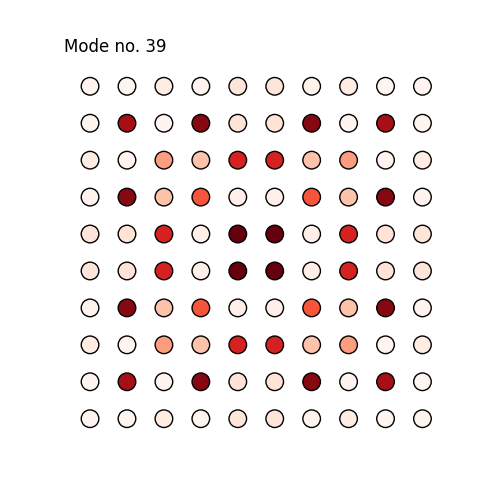

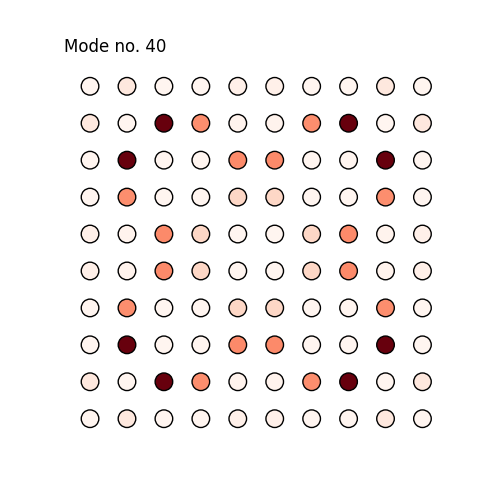

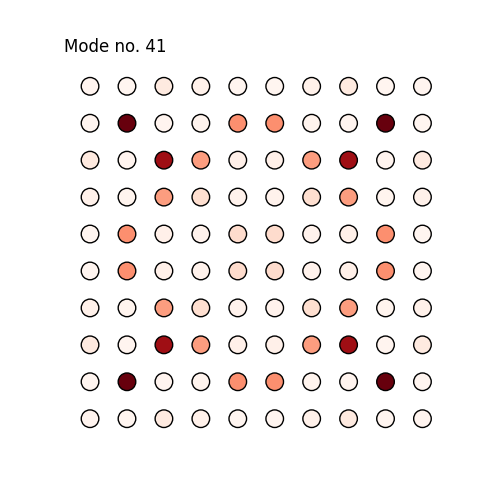

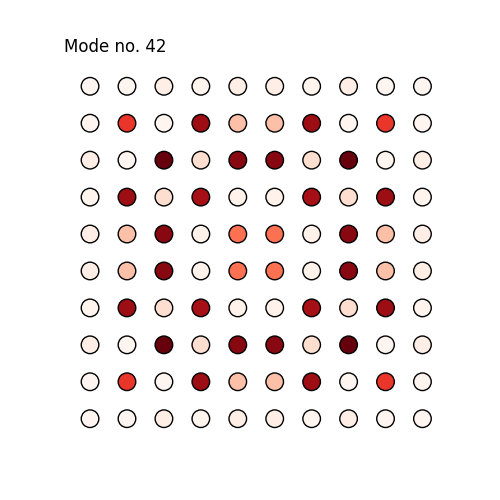

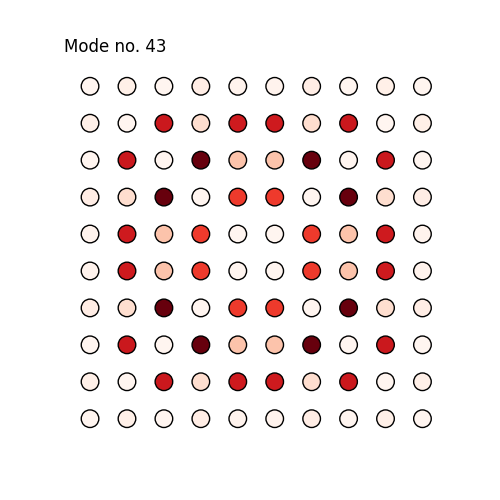

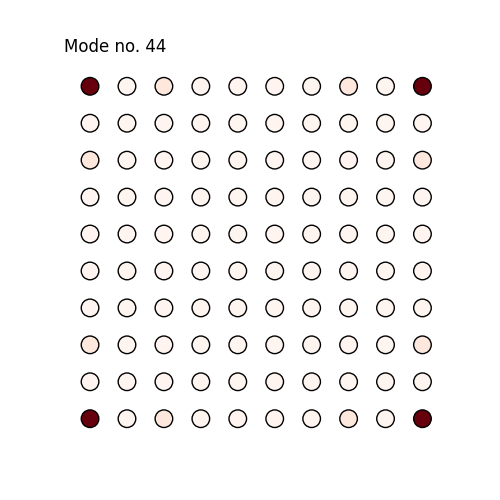

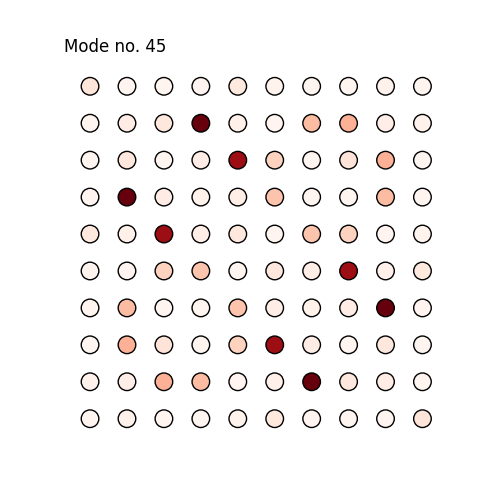

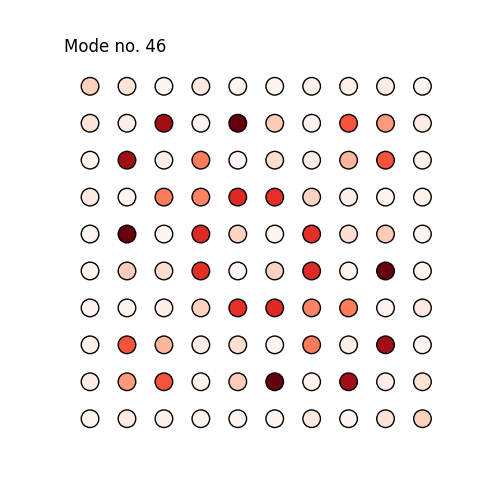

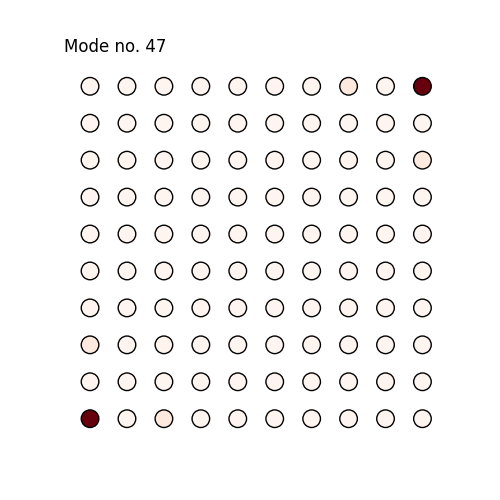

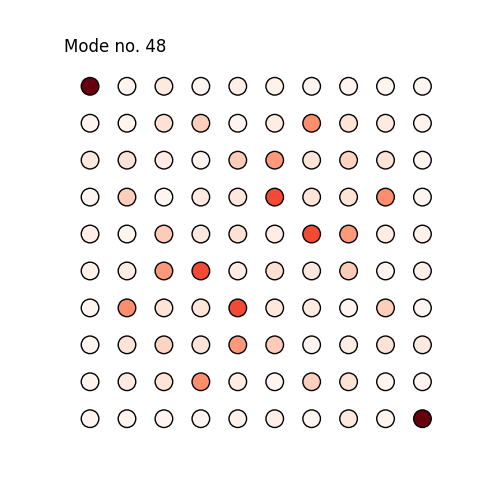

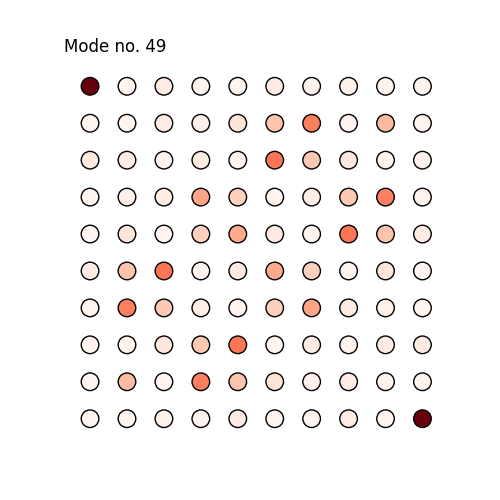

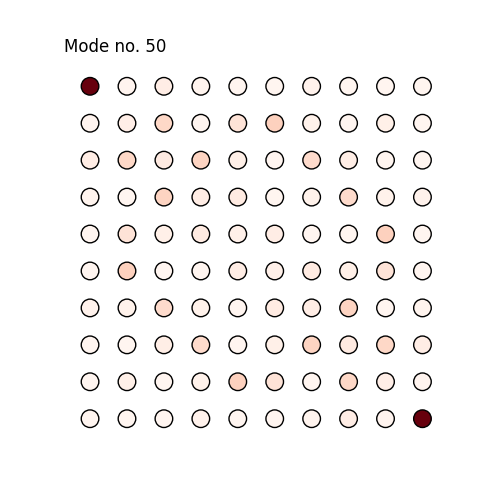

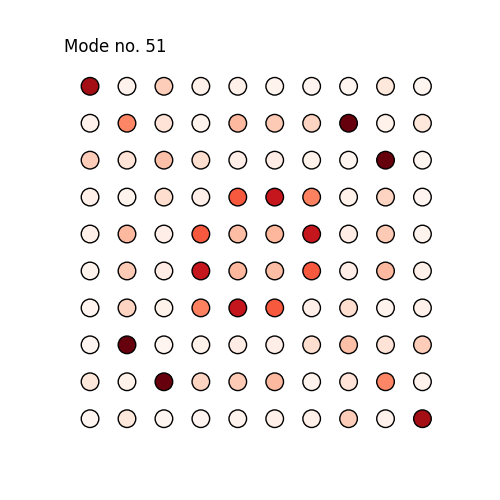

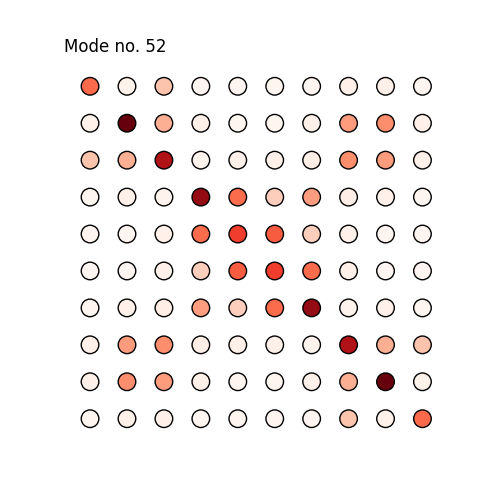

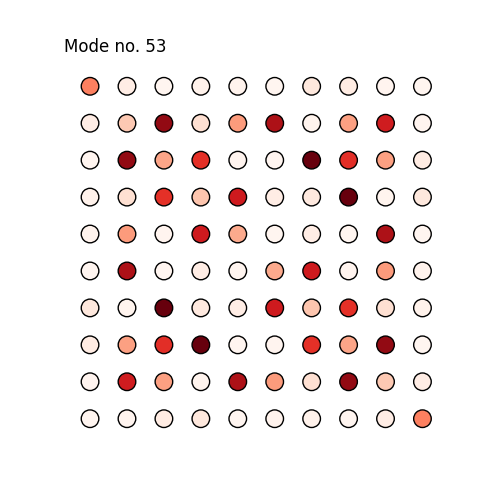

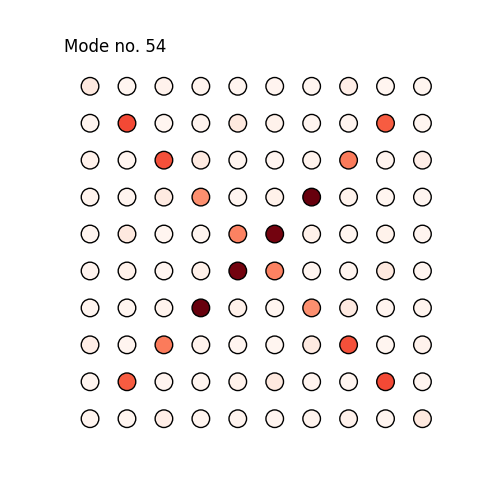

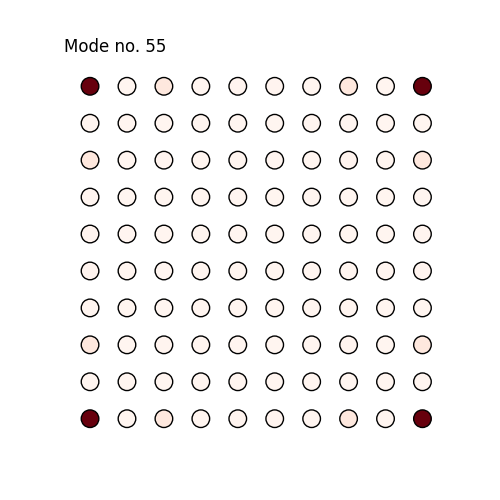

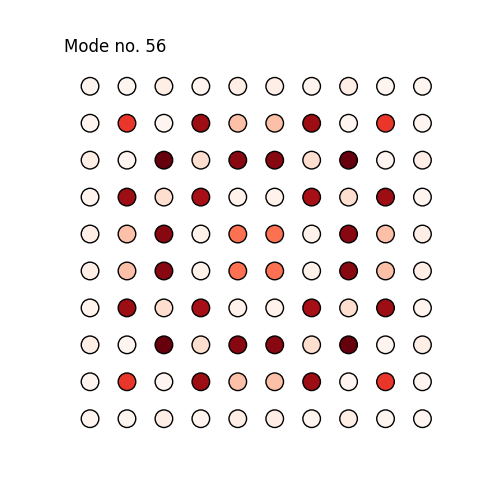

In [41]:
for i in range(27,57):
    intensity = betavecs[:,i]*np.conjugate(betavecs[:,i])
    intensity = intensity/np.sum(intensity)
    plot_coloured_chain(intensity, 3, b_10_list,i)